In [1]:
import psutil
import h5py
import os
import numpy as np

data_filepath = os.path.join("data", "CERN", "ParticleClassification")
photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

def printH5PYFile(file : h5py.File) -> None:
    keys = file.keys()
    print(f"for {file}")
    print("found keys : ", keys)
    for k in keys:
        print(f"Shape of key {k} is {file[k].shape}")

printH5PYFile(electronFile)
print("")
printH5PYFile(photonFile)
print("")

for <HDF5 file "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5" (mode r)>
found keys :  <KeysViewHDF5 ['X', 'y']>
Shape of key X is (249000, 32, 32, 2)
Shape of key y is (249000,)

for <HDF5 file "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5" (mode r)>
found keys :  <KeysViewHDF5 ['X', 'y']>
Shape of key X is (249000, 32, 32, 2)
Shape of key y is (249000,)



In [2]:
ElectronX, ElectronY = electronFile["X"], electronFile["y"]
PhotonX, PhotonY = photonFile["X"], photonFile["y"]
totalBytes = ElectronX.nbytes + ElectronY.nbytes + PhotonX.nbytes + PhotonY.nbytes
print(f"Total size of the whole dataset in bytes is {totalBytes } B , {round(totalBytes / (1024 * 1024 * 1024),2)} GB")

Total size of the whole dataset in bytes is 4081608000 B , 3.8 GB


1.7608888


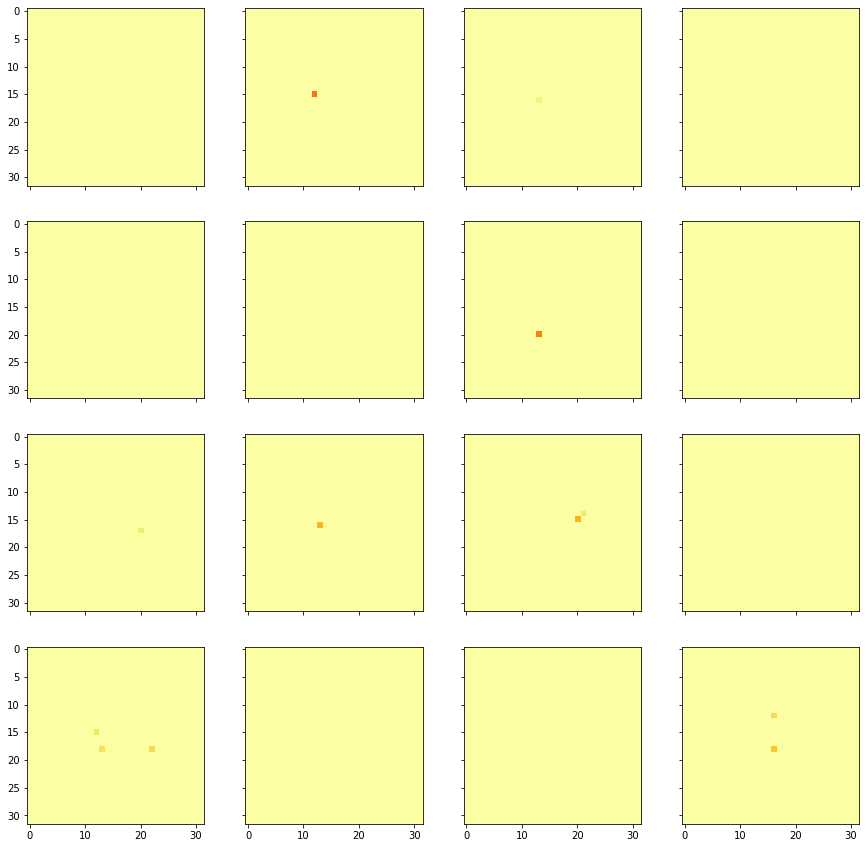

In [65]:
import matplotlib.pyplot as plt

def plotSquareMatrix(dataset, nImagesToPlot, channel):
    nImages = dataset.shape[0]
    indexes = sorted(np.random.permutation(nImages)[:nImagesToPlot*nImagesToPlot])
    fig, axs = plt.subplots(nImagesToPlot, nImagesToPlot, figsize=(15,15), sharex=True, sharey=True)
    i = 0
    offset = min(np.min(ElectronX[:, :, :, channel]), 0)

    M = np.max(dataset[indexes, :, :, channel])
    print(M)

    for y in range(nImagesToPlot):
        for x in range(nImagesToPlot):
            idx = indexes[i]
            axs[y, x].imshow(dataset[idx, :, :, channel] - offset, cmap="inferno", vmin=0, vmax=M)
            i += 1

plotSquareMatrix(ElectronX, 4, 1)
plt.show()

1.2512453


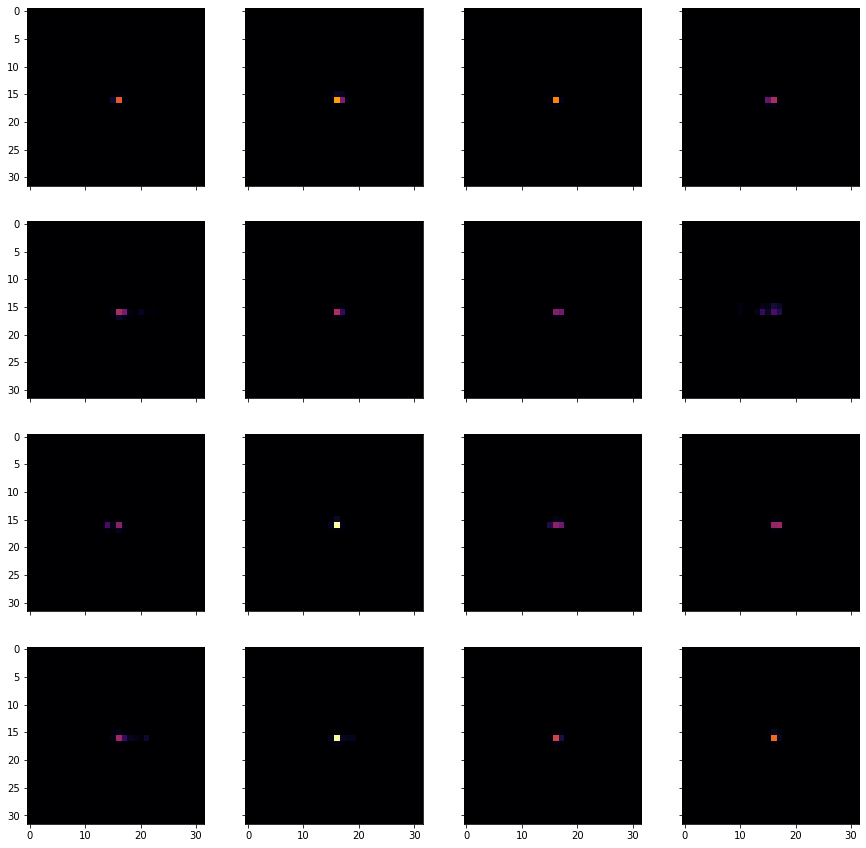

In [66]:
plotSquareMatrix(PhotonX, 4, 0)
plt.show()

In [5]:
whole_dataset_X = np.concatenate([ElectronX, PhotonX])
whole_dataset_Y = np.concatenate([ElectronY, PhotonY])

In [6]:
mu = [np.mean(whole_dataset_X[:, :, :, 0]), np.mean(whole_dataset_X[:, :, :, 1])]
sigma = [np.std(whole_dataset_X[:, :, :, 0]), np.std(whole_dataset_X[:, :, :, 1])]
print("mu = ", mu)
print("sigma = ", sigma)

mu =  [0.001219672, -0.0002618075]
sigma =  [0.023721104, 0.06738354]


## Mean images

In [7]:
meanPhotonX = np.mean(PhotonX, axis=0)
meanElectronX = np.mean(ElectronX, axis=0)
print(meanPhotonX.shape)
print(meanElectronX.shape)

(32, 32, 2)
(32, 32, 2)


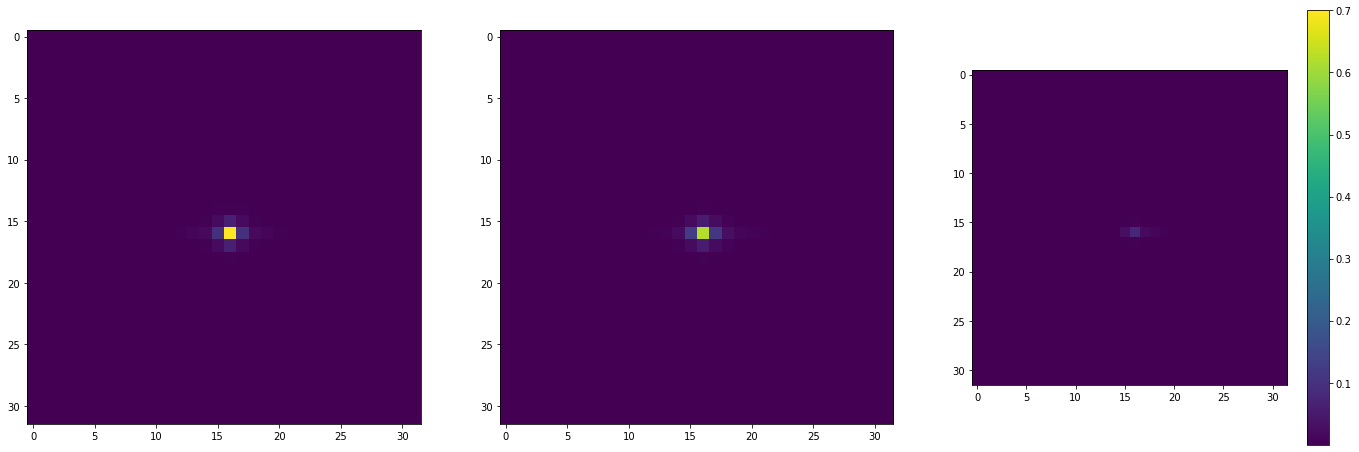

In [55]:
n = 8
plt.figure(figsize=(3*n, 1*n))

M = max(np.max(meanPhotonX[:,:,0]), np.max(meanElectronX[:,:, 0]))
m = min(np.min(meanPhotonX[:,:,0]), np.min(meanElectronX[:,:, 0]))

plt.subplot(1, 3, 1)
plt.imshow(meanPhotonX[:,:,0], vmin=m, vmax=M)

plt.subplot(1, 3, 2)
plt.imshow(meanElectronX[:, :, 0], vmin=m, vmax=M)

plt.subplot(1,3,3)
difference = np.abs(meanPhotonX[:,:,0] - meanElectronX[:,:, 0])
plt.imshow(difference, vmin=m, vmax=M)

plt.colorbar()
plt.show()

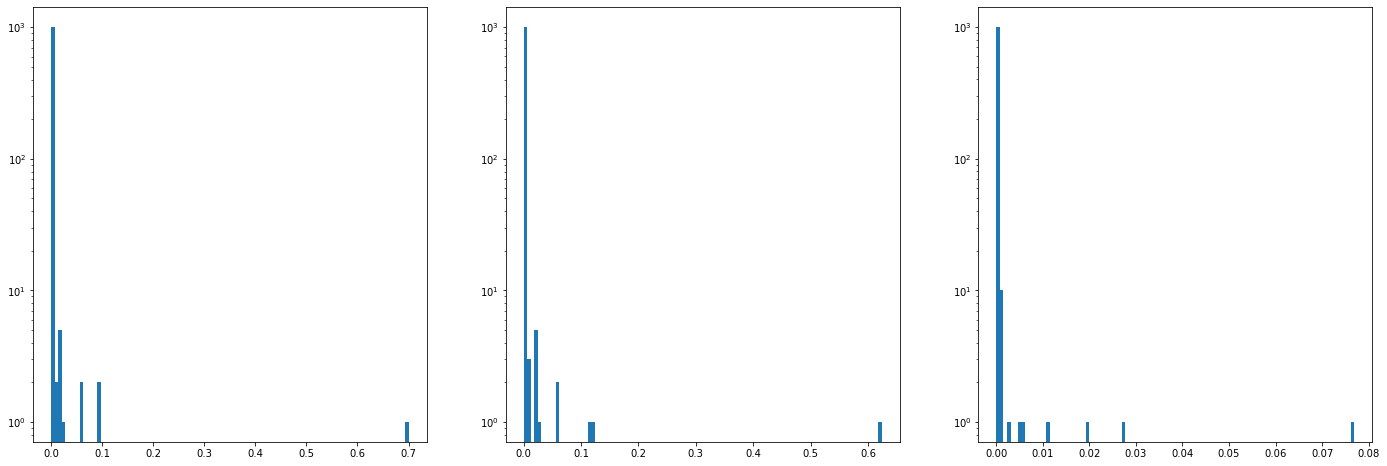

In [60]:
n = 8
plt.figure(figsize=(3*n, 1*n))

plt.subplot(1, 3, 1)
plt.hist(meanPhotonX[:,:,0].reshape(-1), bins=100, log=True)

plt.subplot(1, 3, 2)
plt.hist(meanElectronX[:, :, 0].reshape(-1), bins=100, log=True)

plt.subplot(1,3,3)
plt.hist(difference.reshape(-1), bins=100, log=True)
plt.show()

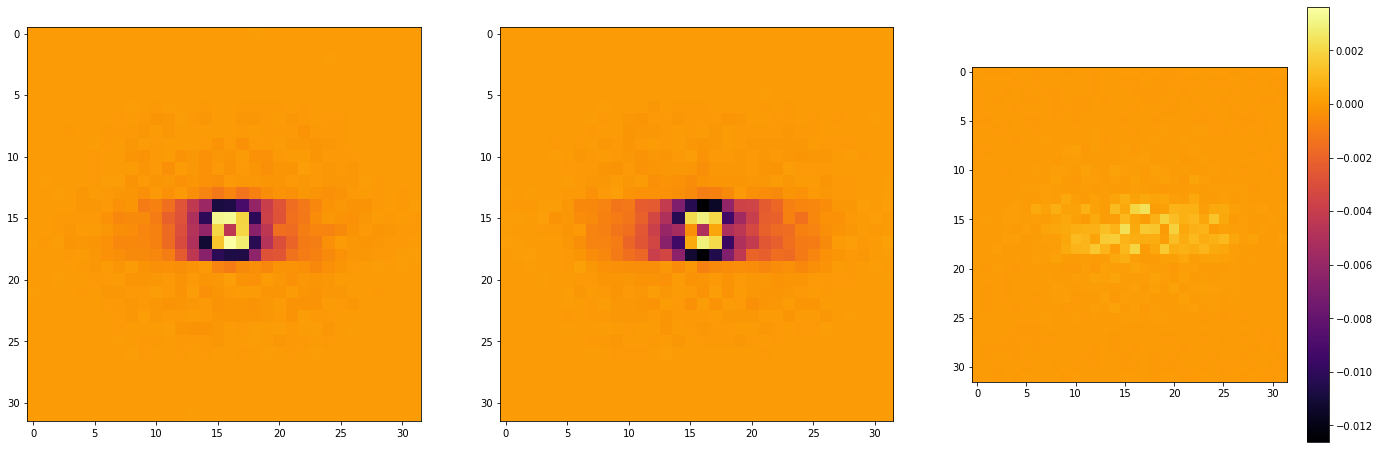

In [62]:
n = 8
plt.figure(figsize=(3*n, 1*n))

M = max(np.max(meanPhotonX[:,:,1]), np.max(meanElectronX[:,:, 1]))
m = min(np.min(meanPhotonX[:,:,1]), np.min(meanElectronX[:,:, 1]))

plt.subplot(1, 3, 1)
plt.imshow(meanPhotonX[:,:,1], vmin=m, vmax=M, cmap="inferno")

plt.subplot(1, 3, 2)
plt.imshow(meanElectronX[:, :, 1], vmin=m, vmax=M, cmap="inferno")

plt.subplot(1,3,3)
difference = np.abs(meanPhotonX[:,:,1] - meanElectronX[:,:, 1])
plt.imshow(difference, vmin=m, vmax=M, cmap="inferno")

plt.colorbar()
plt.show()

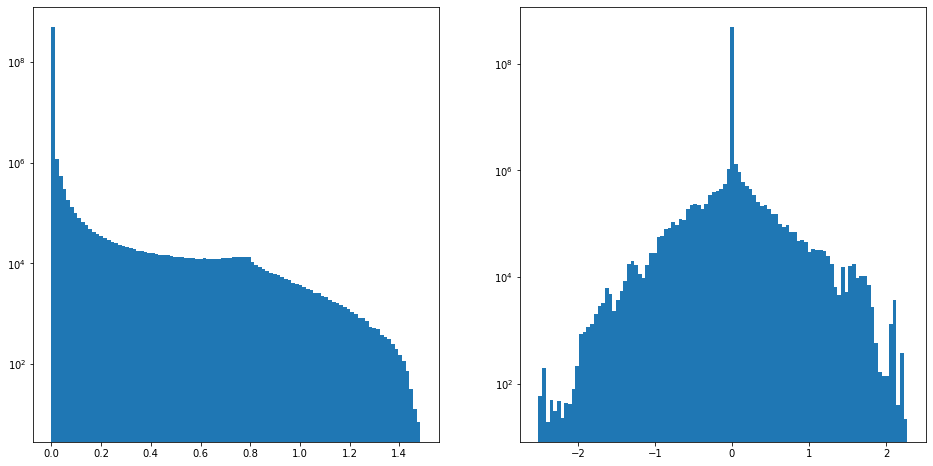

In [10]:
unraveled = whole_dataset_X.reshape(-1, 2)
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.hist(unraveled[:, 0], bins=100, log=True)
plt.subplot(1, 2, 2)
plt.hist(unraveled[:, 1], bins=100, log=True)
plt.show()

In [11]:
print("Energy ")
hist = np.histogram(unraveled[:, 0], bins=10)
for (x,y) in zip(hist[0], hist[1]):
    print(f"{x} : {y}")

Energy 
509018322 : 0.0
321725 : 0.1484944373369217
174262 : 0.2969888746738434
133580 : 0.4454832971096039
126181 : 0.5939777493476868
103506 : 0.7424721717834473
45013 : 0.8909665942192078
20341 : 1.0394610166549683
7568 : 1.1879554986953735
1502 : 1.3364498615264893


In [12]:
print("Time ")
hist = np.histogram(unraveled[:, 1], bins=10)
for (x,y) in zip(hist[0], hist[1]):
    print(f"{x} : {y}")

Time 
595 : -2.512557029724121
23433 : -2.0335042476654053
111955 : -1.5544517040252686
776053 : -1.0753989219665527
2893444 : -0.5963462591171265
504350801 : -0.1172935962677002
1341413 : 0.36175909638404846
342336 : 0.8408117890357971
102767 : 1.3198645114898682
9203 : 1.7989171743392944


In [13]:
HitEnergyElectron = ElectronX[:, :, :, 0]
HitEnergyPhoton = ElectronX[:, :, :, 0]

eps = 1e-4

I2HitEnergyElectron = np.sqrt(np.sum(HitEnergyElectron.reshape(-1, 32 * 32)**2, axis=1)) + eps
HitEnergyElectron = np.abs(HitEnergyElectron) / I2HitEnergyElectron.reshape(-1,1,1)

I2HitEnergyPhoton = np.sqrt(np.sum(HitEnergyElectron.reshape(-1, 32 * 32)**2, axis=1)) + eps
HitEnergyPhoton = np.abs(HitEnergyPhoton) / I2HitEnergyPhoton.reshape(-1,1,1)

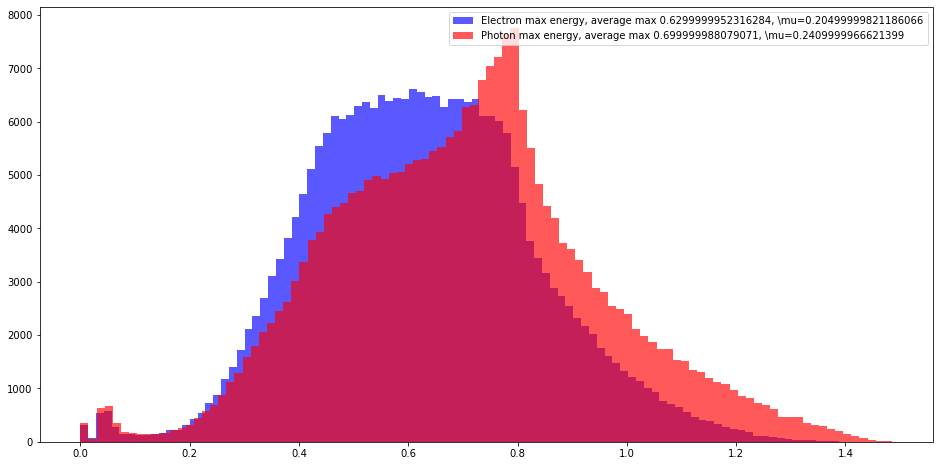

In [31]:
plt.figure(figsize=(16,8))
ElectronAverageMaxEnergy = np.mean(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1))
roundedElectronAverageMaxEnergy = round(ElectronAverageMaxEnergy, 2)
roundedElectronStdMaxEnergy = round(np.std(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1)), 3)

plt.hist(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1), bins=100, color="blue", alpha=0.65, label=f"Electron max energy, average max {roundedElectronAverageMaxEnergy}, \mu={roundedElectronStdMaxEnergy}")
ElectronAverageMaxEnergy = np.mean(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1))
roundedPhotonAverageMaxEnergy = round(ElectronAverageMaxEnergy, 2)
roundedPhotonStdMaxEnergy = round(np.std(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1)), 3)
plt.hist(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1), bins=100, color="red", alpha=0.65, label=f"Photon max energy, average max {roundedPhotonAverageMaxEnergy}, \mu={roundedPhotonStdMaxEnergy}")
plt.legend()
plt.show()

(32, 32)
(32, 32)


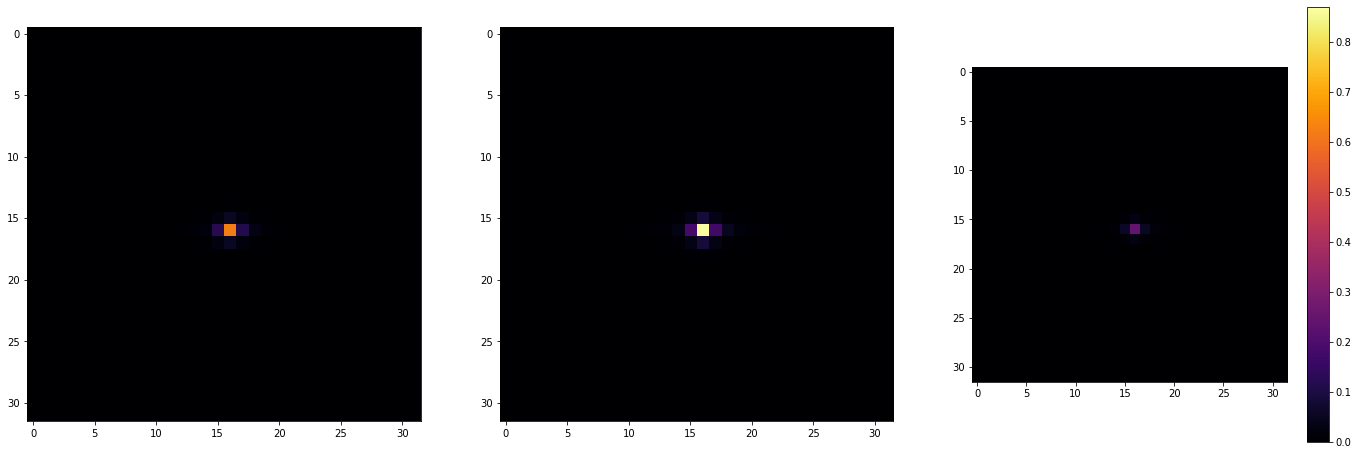

In [52]:
meanPhotonXScaled = np.mean(HitEnergyPhoton, axis=0)
meanElectronXScaled = np.mean(HitEnergyElectron, axis=0)
print(meanPhotonXScaled.shape)
print(meanElectronXScaled.shape)

plt.figure(figsize=(24,8))
plt.subplot(1, 3, 1)
plt.imshow(meanPhotonXScaled, vmin=0, vmax=0.87, cmap="inferno")

plt.subplot(1, 3, 2)
plt.imshow(meanElectronXScaled, vmin=0, vmax=0.87, cmap="inferno")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(meanPhotonXScaled - meanElectronXScaled), vmin=0, vmax=0.87, cmap="inferno")
plt.colorbar()